# Quantum Game Theory - Maze Pathway Solving

A maze-solving algorithm is an automated method for solving a maze. The random mouse, wall follower, Pledge, and Trémaux's algorithms are designed to be used inside the maze by a traveler with no prior knowledge of the maze, whereas the dead-end filling and shortest path algorithms are designed to be used by a person or computer program that can see the whole maze at once. 

Coded by Y3TI & Sam Rahmeh

In [1]:
import numpy as np
import random
import dimod
import dynex
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

In [2]:
def generateMaze(dim):
    maze = np.ones((dim * 2 + 1, dim * 2 + 1))
    stack = [(0, 0)]
    while stack:
        x, y = stack.pop()
        directions = [(dx, dy) for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]]
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < dim and 0 <= ny < dim and maze[2 * nx + 1, 2 * ny + 1] == 1:
                maze[2 * nx + 1, 2 * ny + 1] = 0
                maze[2 * x + 1 + dx, 2 * y + 1 + dy] = 0
                stack.append((nx, ny))
    maze[1, 0] = 0
    maze[-2, -1] = 0
    return maze

def buildBQM(maze):
    rows, cols = maze.shape
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    pathIncentive = -1000
    connectivityReward = 200
    directionalBiasFactor = 0.1
    extraPenaltyForTurns = -50
    exitPoint = (rows - 2, cols - 1)
    for rowIndex in range(rows):
        for columnIndex in range(cols):
            if maze[rowIndex, columnIndex] != 1:
                distanceToExit = abs(exitPoint[0] - rowIndex) + abs(exitPoint[1] - columnIndex)
                directionalIncentive = pathIncentive - directionalBiasFactor * distanceToExit
                bqm.add_variable((rowIndex, columnIndex), directionalIncentive)
    for rowIndex in range(rows):
        for columnIndex in range(cols):
            if (rowIndex, columnIndex) in bqm.linear:
                if rowIndex > 0 and (rowIndex - 1, columnIndex) in bqm.linear:
                    verticalBias = connectivityReward
                    if rowIndex > exitPoint[0]:
                        verticalBias /= 2
                    bqm.add_interaction((rowIndex, columnIndex), (rowIndex - 1, columnIndex), verticalBias)
                if columnIndex > 0 and (rowIndex, columnIndex - 1) in bqm.linear:
                    horizontalBias = connectivityReward
                    if columnIndex > exitPoint[1]:
                        horizontalBias /= 2
                    bqm.add_interaction((rowIndex, columnIndex), (rowIndex, columnIndex - 1), horizontalBias)
                if rowIndex > 0 and columnIndex > 0 and (rowIndex - 1, columnIndex - 1) in bqm.linear:
                    diagonalInteractionPenalty = extraPenaltyForTurns
                    bqm.add_interaction((rowIndex, columnIndex), (rowIndex - 1, columnIndex - 1), diagonalInteractionPenalty)
                if rowIndex < rows - 1 and columnIndex < cols - 1 and (rowIndex + 1, columnIndex + 1) in bqm.linear:
                    if rowIndex < exitPoint[0] and columnIndex < exitPoint[1]:
                        diagonalInteractionReward = connectivityReward / 3
                        bqm.add_interaction((rowIndex, columnIndex), (rowIndex + 1, columnIndex + 1), diagonalInteractionReward)
    return bqm

def solveMaze(bqm, num_reads=20000, annealing_time=1000):
    model = dynex.BQM(bqm)
    sampler = dynex.DynexSampler(model, mainnet=False, description='Quantum Maze Solver', bnb=False)
    sampleset = sampler.sample(num_reads=num_reads, annealing_time=annealing_time, debugging=False, alpha=10, beta=1)
    solution = sampleset.first.sample
    return solution

def bfsAlgorithm(start, goal, graph):
    queue = deque([start])
    path = {start: None}
    while queue:
        current = queue.popleft()
        if current == goal:
            break
        for neighbor in graph[current]:
            if neighbor not in path:  
                queue.append(neighbor)
                path[neighbor] = current  
    if goal in path:
        step = goal
        path_sequence = []
        while step is not None:
            path_sequence.append(step)
            step = path.get(step)
        return path_sequence[::-1]  
    else:
        return None 

def visualizeSolution(maze, solution=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if solution is not None:
        graph = {}
        path_nodes = [node for node, active in solution.items() if active == 1]
        for node in path_nodes:
            graph[node] = []
            neighbors = [(node[0] + dx, node[1] + dy) for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]]
            for neighbor in neighbors:
                if neighbor in path_nodes:
                    graph[node].append(neighbor)
        start_point = (1, 0)
        exit_point = (maze.shape[0]-2, maze.shape[1]-1)
        path = bfsAlgorithm(start_point, exit_point, graph)
        if path:
            x_data = [p[1] for p in path]
            y_data = [p[0] for p in path]
            ax.plot(x_data, y_data, color='red', linewidth=2)
        else:
            print("No path found")
    plt.show()

In [3]:
# Any Maze Size larger than 30 requires mainnet=True in the solveMaze function
mazeSize = 150

[DYNEX] MAZE GENERATED TO SIZE: 150


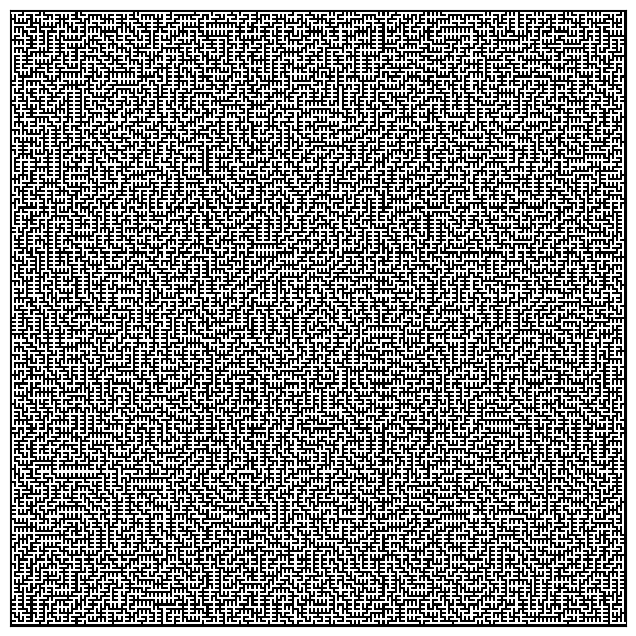

In [4]:
print("[DYNEX] MAZE GENERATED TO SIZE:", mazeSize)
maze = generateMaze(mazeSize)
visualizeSolution(maze, None)

In [5]:
# Compute using Dynex
num_reads = 20000
annealing_time = 1000
print("[DYNEX] BUILDING BQM JOB PLEASE WAIT.....")
bqm = buildBQM(maze)
solution = solveMaze(bqm, num_reads,annealing_time)

[DYNEX] BUILDING BQM JOB PLEASE WAIT.....
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │    45009 │          102057 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.54 SECONDS
[DYNEX] SAMPLESET READY


[DYNEX] MAZE SOLUTION FOUND FOR MAZE SIZE: 150


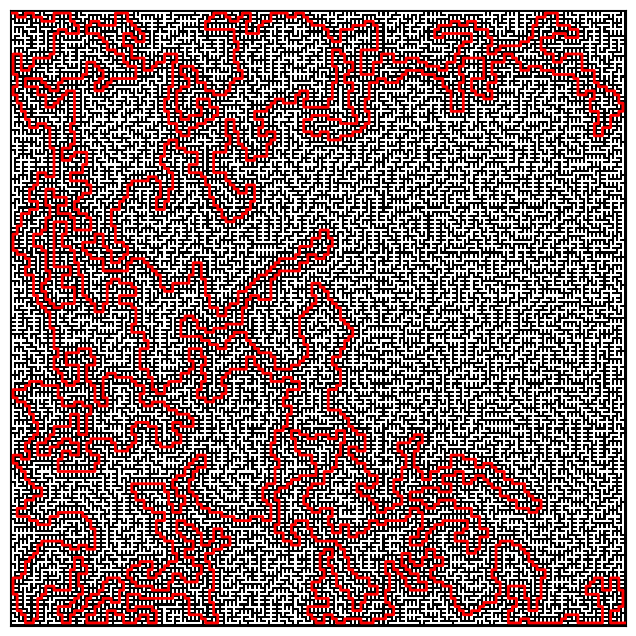

In [6]:
if solution:
    print("[DYNEX] MAZE SOLUTION FOUND FOR MAZE SIZE:", mazeSize)
    visualizeSolution(maze, solution)
else:
    print("[DYNEX] MAZE SOLUTION NOT FOUND FOR MAZE SIZE:", mazeSize)